In [7]:
%matplotlib inline
import network.network as Network
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [6]:
infile = open("train", "rb")
training_data = np.load(infile, encoding='latin1')
infile.close()

infile2 = open("test", "rb")
test_data = np.load(infile2, encoding='latin1')
infile2.close()

with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

In [46]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

def adversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x
        x -= eta * d
        
    return x

# Wrapper function
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    # a = adversarial(net, n, 1000, 1)
    a = adversarial(net, n, 1000, 0.15)
    x = np.round(net.feedforward(a), 2)
    
    print('Network Output: \n' + str(x) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Adversarial Example: ')
    plt.imshow(a.reshape(28,28), cmap='Greys')
    
def sneaky_adversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    # x = np.random.normal(.5, .3, (784, 1))
    
    # Initialize noise to 0
    noise = np.zeros((784, 1), dtype=float)

    # Gradient descent on the input
    for i in range(steps):
        print("Iteration: ", i)
        
        noisy_image = x_target + noise
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=1.0)
        
        # Do the prediction
        pred = net.feedforward(noisy_image)
        score_target = pred[n]
        
        # Calculate the derivative
        grad = input_derivative(net,noisy_image,goal)
        sq_grad = np.array(grad).squeeze()
        grad_absmax = np.abs(grad).max()
        
        # If the gradient is very small then use a lower limit,
        # because we will use it as a divisor.
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10
            
        # Calculate the step-size for updating the image-noise.
        # This ensures that at least one pixel colour is changed by 7.
        # Recall that pixel colours can have 255 different values.
        # This step-size was found to give fast convergence.
        step_size = 0.01 / grad_absmax
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        # x -= eta * (grad + lam * (x - x_target))
        
        if score_target < 0.5:
            # Update the image-noise by subtracting the gradient
            # scaled by the step-size.
            noise -= step_size * grad

            # Ensure the noise is within the desired range.
            # This avoids distorting the image too much.
            noise = np.clip(a=noise,
                            a_min=-1.0,
                            a_max=1.0)
        else:
            # Abort the optimization because the score is high enough.
            break

    return noisy_image

# Wrapper function
def sneaky_generate(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    # net, n, x_target, steps, eta, lam=.05
    a = sneaky_adversarial(net, n, test_data[idx][0], 1000, 0.1, lam=0.05)
    # x = np.round(net.feedforward(a), 2)
    x = net.feedforward(a)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_data[idx][0].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    #print('Network Output: \n' + str(x) + '\n')
    print("Network Output:")
    print(x)
    
    return a

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59

What we want our adversarial example to look like: 


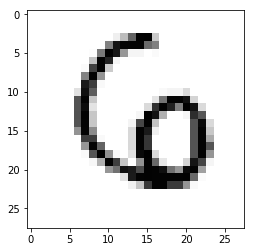



Adversarial Example: 


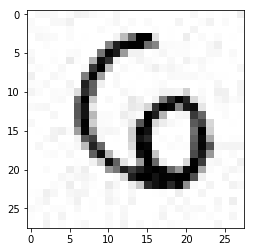

Network Prediction: 1

Network Output:
[[5.59463958e-12]
 [5.34999986e-01]
 [9.28487650e-04]
 [1.70683425e-04]
 [4.49291224e-09]
 [6.24584055e-06]
 [4.19229838e-03]
 [1.90168571e-16]
 [8.41204835e-09]
 [2.03746317e-13]]


In [64]:
adv_ex = sneaky_generate(1, 6)

In [13]:
idx = 0
test_data[idx][0].shape

(784, 1)

In [35]:
pred = net.feedforward(adv_ex)
print("Network Prediction: ", str(np.argmax(pred)))
print(pred)

Network Prediction:  7
[[3.84940104e-10]
 [3.09685480e-09]
 [2.71110833e-06]
 [2.50655822e-09]
 [7.76256740e-08]
 [5.71491074e-06]
 [1.28826623e-05]
 [7.98682411e-05]
 [5.99688781e-05]
 [1.84192658e-05]]
